## Introduction

In this notebook, we are going to fine-tune the LayoutLM model by Microsoft Research on the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, which is a collection of annotated form documents. The goal of our model is to learn the annotations of a number of labels ("question", "answer", "header" and "other") on those forms, such that it can be used to annotate unseen forms in the future.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318

* Original FUNSD paper: https://arxiv.org/abs/1905.13538


## Install libraries

Currently you have to first install the `unilm` package, and then the `transformers` package (which updates the outdated `transformers` package that is included in the `unilm` package). The reason we also install the `unilm` package is because we need its preprocessing files. I've forked it, and removed some statements which introduced some issues.

In [1]:
import torch

In [2]:
# ! rm -r unilm
# ! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
# ! cd unilm/layoutlm
# ! pip install unilm/layoutlm

In [3]:
# ! rm -r transformers
# ! git clone https://github.com/huggingface/transformers.git
# ! cd transformers
# ! pip install ./transformers

## Getting the data

Here we download the data of the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/) from the web. This results in a directory called "data" being created, which has 2 subdirectories, one for training and one for testing. Each of those has 2 subdirectories in turn, one containing the images as png files and one containing the annotations in json format.

In [4]:
# ! wget https://guillaumejaume.github.io/FUNSD/dataset.zip
# ! unzip dataset.zip && mv dataset data && rm -rf dataset.zip __MACOSX

Let's take a look at a training example. For this, we are going to use PIL (Python Image Library).

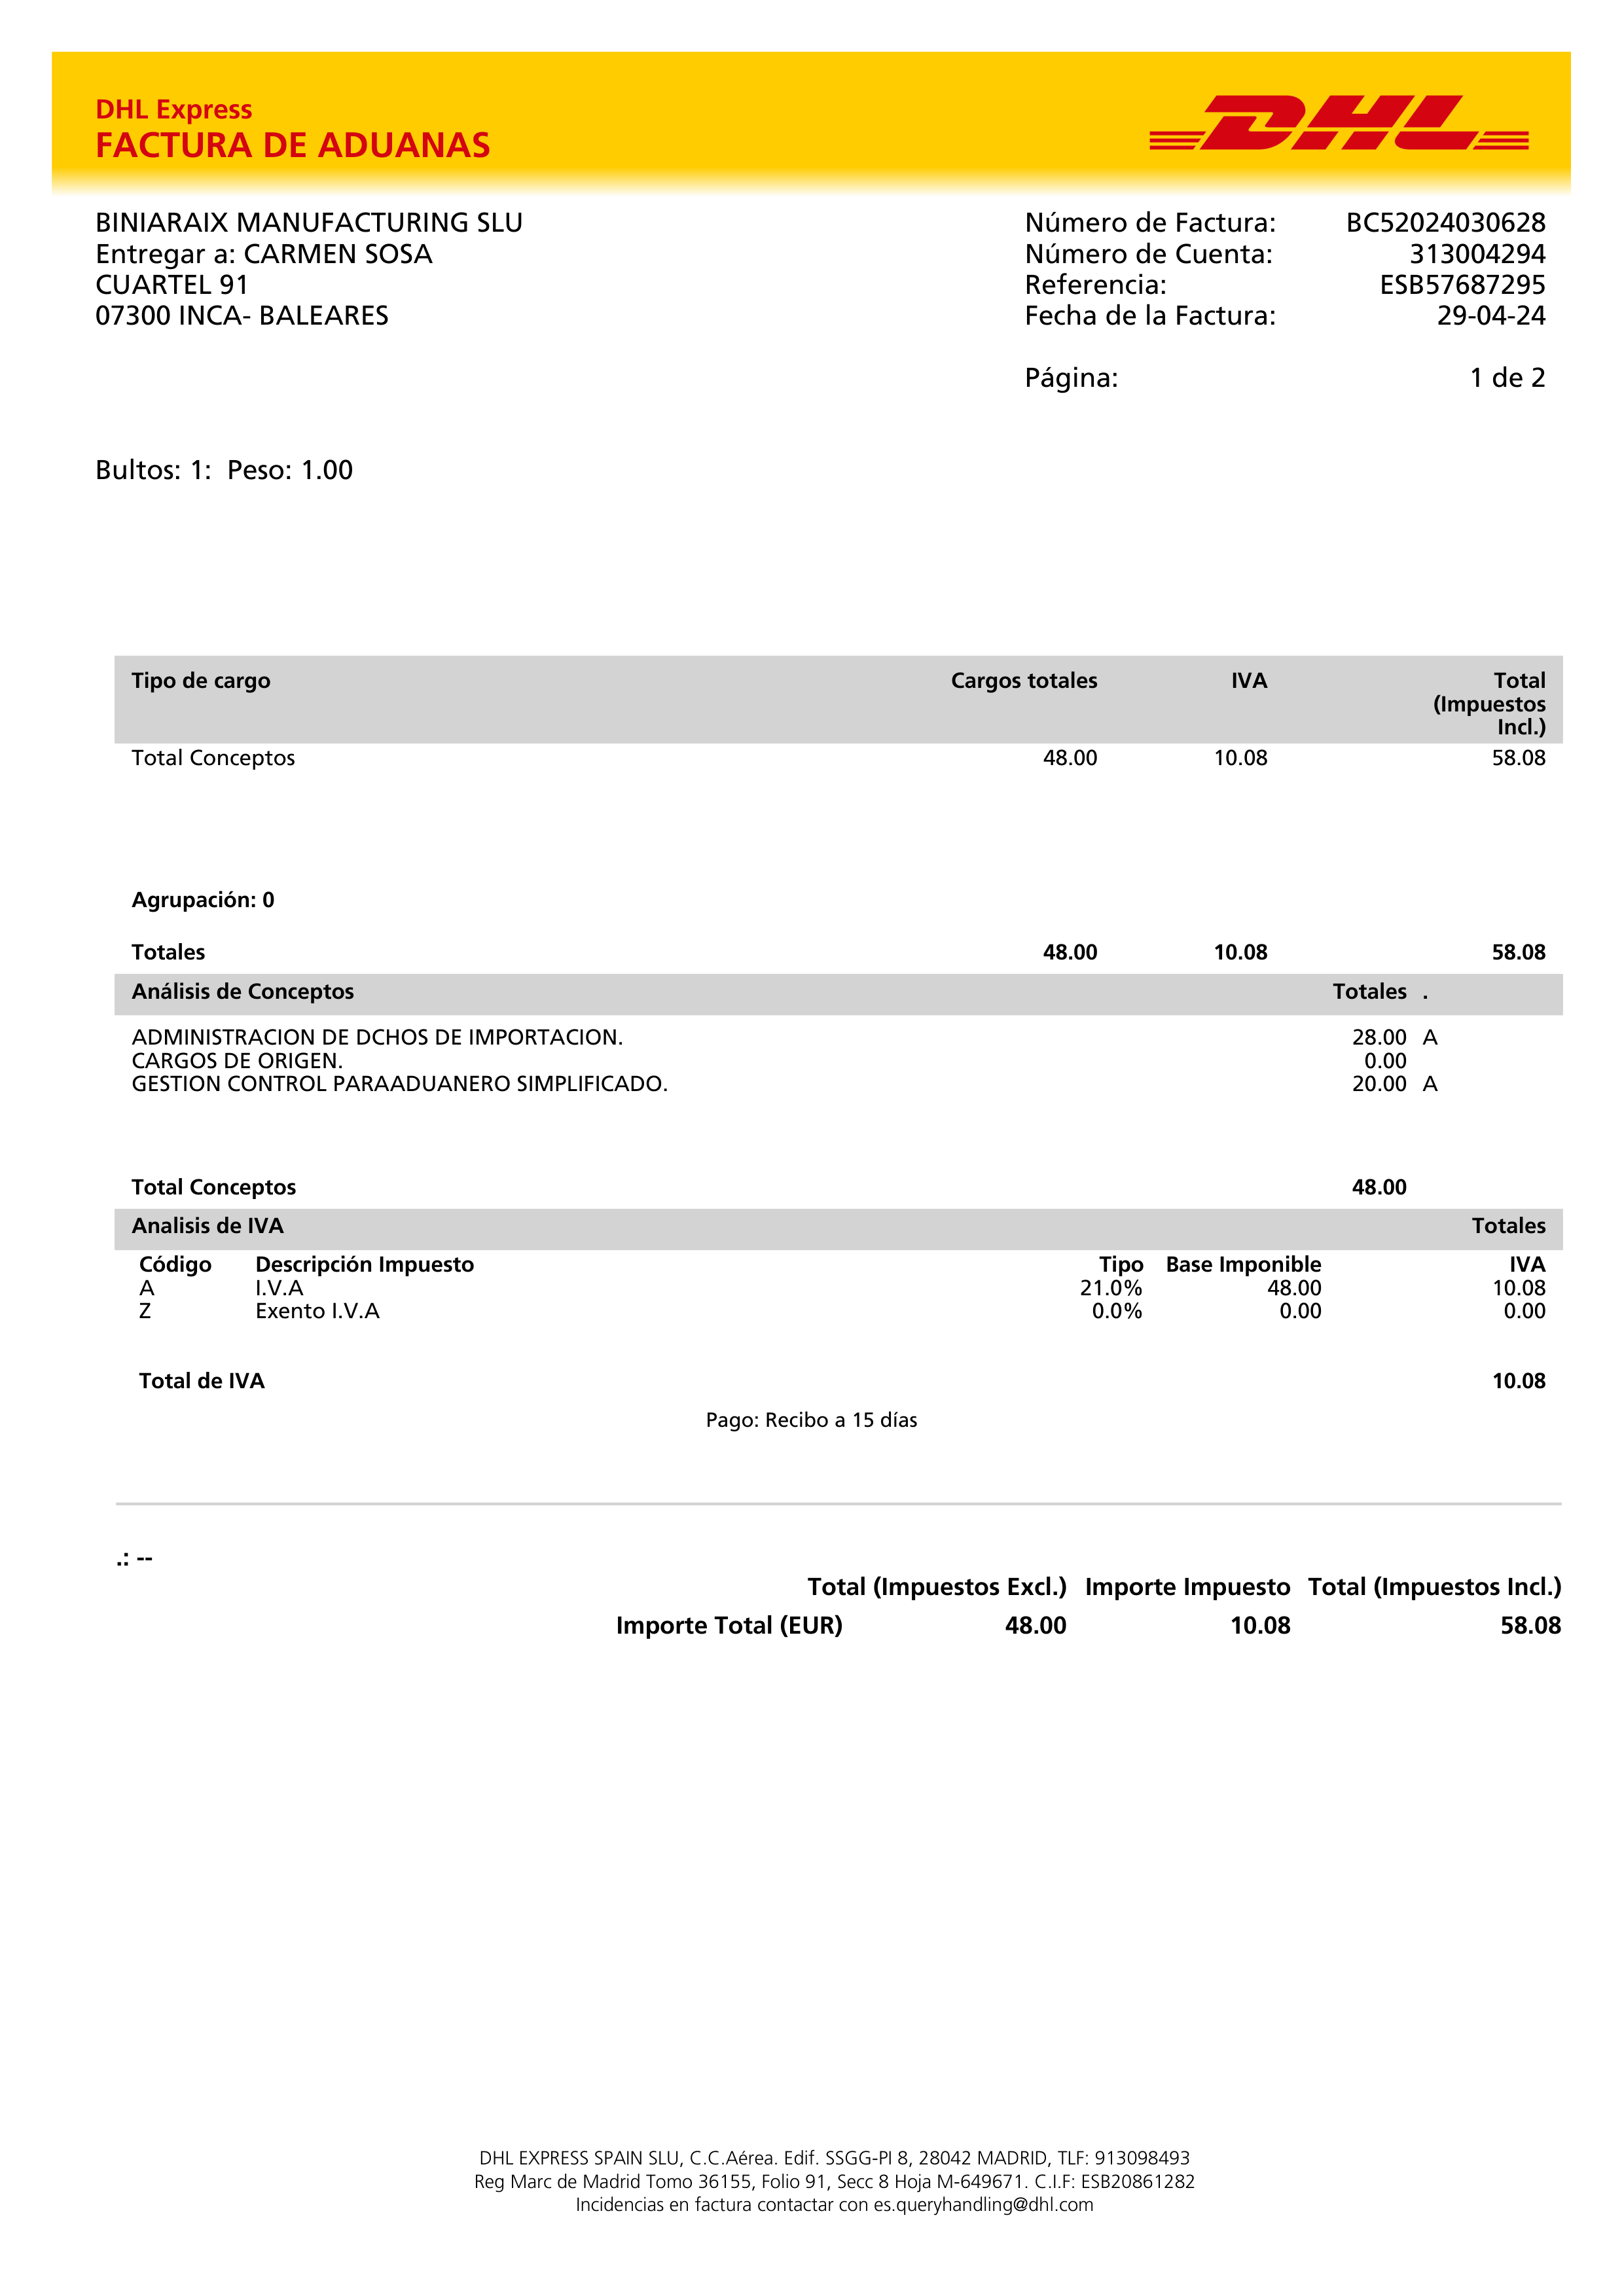

In [5]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(fr"dataset\testing_data\images\TC_Page_1.png")
image = image.convert("RGB")
image

Now let's plot its corresponding annotations. Basically, if you type `data['form']`, you get a list of all general annotations. Each general annotation has a label, a bounding box, and one or more words, which in also have their own bounding box. The bounding boxes are in [xleft, ytop, xright, ybottom] format.
 

In [6]:
import json

with open(fr'dataset\training_data\annotations\TC_PAGE_1.json') as f:
  data = json.load(f)
print(data)
for annotation in data['form']:
  print(annotation)

{'form': [{'box': [149, 152, 226, 181], 'text': 'DHL', 'label': 'others', 'words': [{'box': [149, 152, 226, 181], 'text': 'DHL'}], 'linking': [], 'id': '5db931cb-9'}, {'box': [241, 152, 384, 190], 'text': 'Express', 'label': 'others', 'words': [{'box': [241, 152, 384, 190], 'text': 'Express'}], 'linking': [], 'id': '574a5a00-4'}, {'box': [1841, 146, 2235, 195], 'text': 'w—»', 'label': 'others', 'words': [{'box': [1841, 146, 2235, 195], 'text': 'w—»'}], 'linking': [], 'id': '60d1c5e3-8'}, {'box': [1993, 142, 2027, 199], 'text': 'Y', 'label': 'others', 'words': [{'box': [1993, 142, 2027, 199], 'text': 'Y'}], 'linking': [], 'id': '23ab59e1-c'}, {'box': [2069, 142, 2103, 199], 'text': '*', 'label': 'others', 'words': [{'box': [2069, 142, 2103, 199], 'text': '*'}], 'linking': [], 'id': '79131247-8'}, {'box': [2136, 142, 2170, 199], 'text': 'f', 'label': 'others', 'words': [{'box': [2136, 142, 2170, 199], 'text': 'f'}], 'linking': [], 'id': 'bf19f446-2'}, {'box': [2202, 142, 2236, 199], 'tex

The PIL library has a handy ImageDraw module, which -you guessed it- allows to draw things (such as rectangles) on an image:

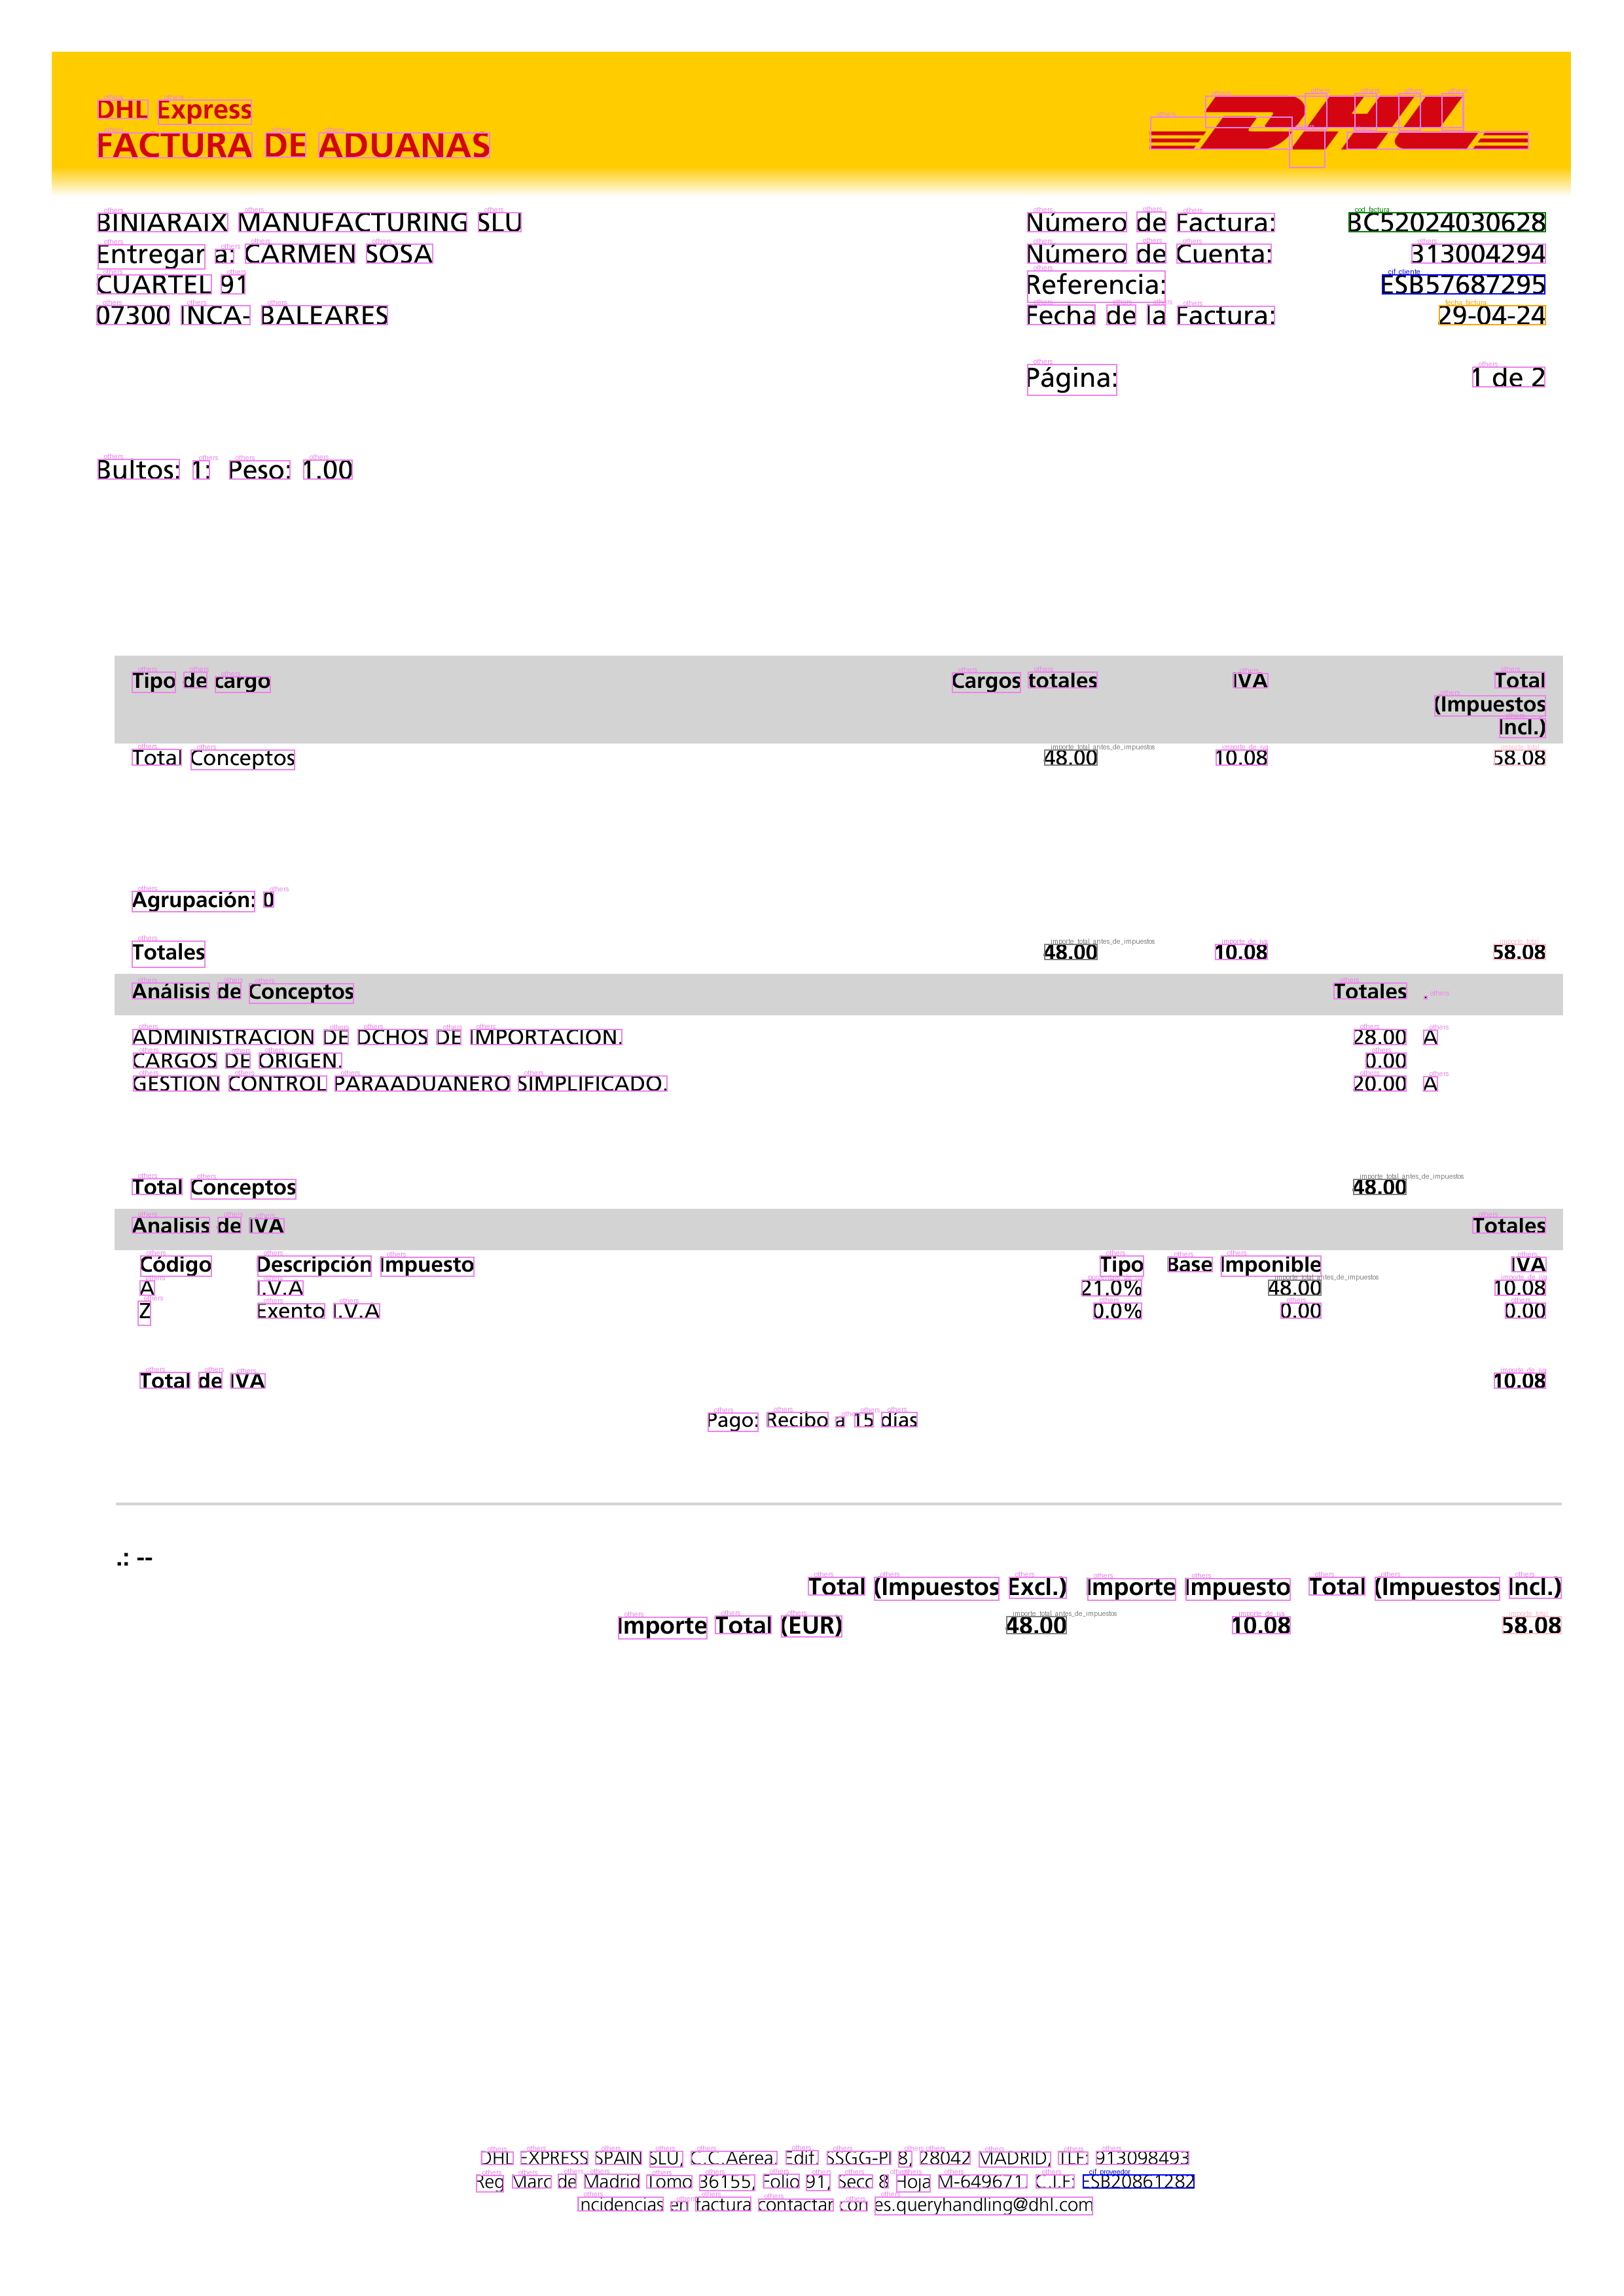

In [7]:
draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {'cif_proveedor':'blue', 'cif_cliente':'blue', 'cod_factura':'green', 'fecha_factura':'orange', 'others':'violet', 'fecha_vencimiento':'magenta', 'importe_total':'pink', 'importe_total_antes_de_impuestos':'grey', 'importe_de_iva':'violet', 'porcentaje_de_iva':'violet'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  if not label:
    continue
    
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)
    
  


image

## Preprocessing the data

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [8]:
! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir dataset/training_data/annotations \
                                                      --data_split train \
                                                      --output_dir dataset/ \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir dataset/testing_data/annotations \
                                                      --data_split test \
                                                      --output_dir dataset/ \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

Next, we create a labels.txt file that contains the unique labels of the FUNSD dataset:

In [9]:
# ! cat dataset/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > dataset/labels.txt

def process_file(input_file, output_file):
    # Abrir el archivo de entrada y leer sus líneas
    with open(input_file, 'r', encoding='utf-8') as f:
        # Leer y dividir las líneas, extrayendo la segunda columna
        lines = f.readlines()
        second_column = [line.split('\t')[1].strip() for line in lines if line.strip()]

    # Eliminar duplicados y ordenar las líneas
    unique_sorted_lines = sorted(set(second_column))

    # Guardar el resultado en el archivo de salida
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("\n".join(unique_sorted_lines) + "\n")

    print(f"Archivo procesado y guardado en {output_file}")

# Uso de la función
input_file = 'dataset/train.txt'
output_file = 'dataset/labels.txt'
process_file(input_file, output_file)


Archivo procesado y guardado en dataset/labels.txt


## Define a PyTorch dataset

First, we create a list containing the unique labels based on `data/labels.txt` (run this from the content directory):

In [10]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("dataset/labels.txt")

num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER: 

In [11]:
print(labels)

['O', 'S-CIF_CLIENTE', 'S-CIF_PROVEEDOR', 'S-COD_FACTURA', 'S-FECHA_FACTURA', 'S-IMPORTE_DE_IVA', 'S-IMPORTE_TOTAL', 'S-IMPORTE_TOTAL_ANTES_DE_IMPUESTOS', 'S-OTHERS', 'S-PORCENTAJE_DE_IVA']


Next, we can create a PyTorch dataset and corresponding dataloader (both for training and evaluation):

In [12]:
from transformers import LayoutLMTokenizer
# from layoutlm.data.funsd import FunsdDataset, InputFeatures

from unilm.layoutlm.layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': 'dataset',
        'model_name_or_path':'layoutlmv3-base',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)

c:\Users\sergi\Desktop\layout_IA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
len(train_dataloader)

1

In [14]:
len(eval_dataloader)

1

In [15]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

'[CLS] dhl express w — » y * f ff h factura de aduanas oe ee biniaraix manufacturing slu numero de factura : bc52024030628 entregar a : carmen sosa numero de cuenta : 313004294 cuartel 91 referencia : esb57687295 07300 inca - baleares fecha de la factura : 29 - 04 - 24 pagina : 1de2 bultos : 1 : peso : 1. 00 tipo de cargo cargos totales iva total ( impuestos incl. ) total conceptos 48. 00 10. 08 58. 08 agrupacion : 0 totales 48. 00 10. 08 58. 08 analisis de conceptos totales. administracion de dchos de importacion. 28. 00 a cargos de origen. 0. 00 gestion control paraaduanero simplificado. 20. 00 a total conceptos 48. 00 analisis de iva totales cedigo descripcien impuesto tipo base imponible iva a iva 21. 0 48. 00 10. 08 zz exento l. v. a 0. 0 0. 00 0. 00 total de iva 10. 08 pago : recibo a 15 dias total ( impuestos excl. ) importe impuesto total ( impuestos incl. ) importe total ( eur ) 48. 00 10. 08 58. 08 dhl express spain slu, c. c. aerea. edif. ssgg - pi 8, 28042 madrid, tlf : 913

## Define and fine-tune the model

As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

In [16]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
 

Now we can start training:

In [17]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 50
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode

model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      print(f"Epoch {epoch}, Labels: {labels}, Unique values: {labels.unique()}")
       

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

c:\Users\sergi\Desktop\layout_IA\.venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
           

Training: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


Epoch 1, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
           

Training: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 2, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
           

Training: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 3, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
           

Training: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 4, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
           

Training: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 5, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
           

Training: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 6, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
           

Training: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch 7, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
           

Training: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 8, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
           

Training: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 9, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
           

Training: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 10, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch 11, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch 12, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 13, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 14, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Epoch 15, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Epoch 16, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 17, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 18, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 19, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 20, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 21, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 22, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 23, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 24, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 25, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 26, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 27, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 28, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 29, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 30, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 31, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 34, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 35, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 36, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 37, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 38, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 39, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 40, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 41, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Epoch 42, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 43, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Epoch 44, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 45, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Epoch 46, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 47, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 48, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

Training: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

Epoch 49, Labels: tensor([[-100,    8, -100,    8,    8, -100, -100,    8,    8,    8,    8,    8,
            8, -100,    8,    8, -100, -100,    8, -100,    8,    8, -100, -100,
         -100,    8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    3,
         -100, -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,
            8,    8, -100,    8, -100, -100,    8,    8, -100, -100,    8, -100,
         -100, -100, -100,    8, -100, -100,    8,    8, -100, -100,    1, -100,
         -100, -100, -100, -100, -100, -100,    8, -100, -100,    8, -100,    8,
         -100, -100,    8, -100,    8,    8,    8, -100, -100,    4, -100, -100,
         -100, -100,    8, -100, -100,    8, -100, -100,    8, -100, -100, -100,
            8, -100,    8, -100, -100,    8, -100, -100,    8, -100,    8,    8,
            8, -100,    8, -100,    8, -100,    8,    8, -100, -100, -100,    8,
         -100, -100, -100,    8,    8, -100,    7, -100, -100,    5, -100, -100,
          

## Evaluation

Now let's evaluate on the test set:

In [18]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

{'loss': 0.006767055951058865, 'precision': np.float64(1.0), 'recall': np.float64(1.0), 'f1': np.float64(1.0)}


In [19]:
PATH='./layoutlm.pt'
torch.save(model.state_dict(), PATH)

## Inference

Now comes the fun part! We can now use the fine-tuned model and test it on unseen data.

Note that LayoutLM relies on an external OCR engine (it's not end-to-end -> that's probably something for the future). The test data itself also contains the annotated bounding boxes, but let's run an OCR engine ourselves.

So let's load in a image of the test set, run our own OCR on it to get the bounding boxes, then run LayoutLM on the individual tokens and visualize the result!

Sources:
* https://www.kaggle.com/jpmiller/layoutlm-starter
* https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0

In [ ]:
# !git clone https://github.com/UBIAI/layout_lm_tutorial.git

fatal: destination path 'layout_lm_tutorial' already exists and is not an empty directory.


In [4]:
from layout_lm_tutorial.layoutlm_preprocess import *
import pytesseract
pytesseract.pytesseract.tesseract_cmd = fr'C:\Program Files\Tesseract-OCR\tesseract.exe'

KeyboardInterrupt: 

In [3]:
image = Image.open("images\TC_page_1.png")
image = image.convert("RGB")
# image

from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("dataset/labels.txt")

num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

NameError: name 'Image' is not defined

In [2]:

model_path='layoutlm.pt'
model=model_load(model_path,num_labels)
image, words, boxes, actual_boxes = preprocess(fr"dataset\testing_data\images\TC_page_1.png")

word_level_predictions, final_boxes=convert_to_features(image, words, boxes, actual_boxes, model)

print(word_level_predictions)
print(final_boxes)

NameError: name 'model_load' is not defined

In [1]:
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()
def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return ""
label2color = {'cif_cliente':'blue', 
               'cif_proveedor':'green', 
               'cod_factura':'orange', 
               'fecha_factura':'violet', 
               'fecha_vencimiento':'red', 
               'importe_de_iva':'yellow', 
               'importe_total':'pink', 
               'importe_total_antes_de_impuestos':'magenta', 
               'porcentaje_de_iva':'cyan', 
               'others':'violet', 
               '':'violet'}

for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).lower()
    if predicted_label == 'fecha_vencimiento':
      print(predicted_label)
      continue
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
    
image.save("resultado.png")

NameError: name 'ImageDraw' is not defined

# Saving Model
